**To-do list**

* ~~Implement usage of structural constraint in GP CaKe.~~
* Run some simulations to test efficacy of EB method for parameter selection.
* ~~Add diagnostic tools.~~
* Add method for setting last parameters (i.e. temporal localization).
* Add univariate approach for large networks.
* Make transposition of (adj_mat, ground_truth) and (parameter_matrices, structural_constraint) consistent. Currently the latter is transposed with respect to the others. Flipping the indices in rearrange_matrix does not seem to be sufficient??
* Use edge-wise noise level and time scale.
* Alternative to K-means: edge-wise estimates.
* Make plotting function generic (i.e. ground truth, scale, etc.)

In [33]:
%matplotlib inline
import numpy as np
import importlib as imp
#from importlib import reload # for python 3

"""
Simulation and GP-CaKe packages.
"""

import gp_cake.simulator as sim
from gp_cake import gpcake
from gp_cake import utility
from gp_cake import diagnostics

In [34]:
p                       = 3
adj_mat                 = np.zeros((p,p))
adj_mat[0,1]            = 1
adj_mat[0,2]            = 1
connection_strength     = 1
time_step               = 0.01
time_period             = 4.
time_range              = np.arange(-time_period / 2, time_period / 2, time_step)
ntime_points            = int(time_period / time_step)
simulation_params       = {'network'                : adj_mat,
                           'connection_strength'    : connection_strength,
                           'time_step'              : time_step,
                           'time_period'            : time_period}

ntrials_train                                       = 300
ntrials_test                                        = 300
simulation                                          = sim.integroDifferential_simulator()
simulation.dynamic_parameters["connectivity_relaxations_constants"] = [[0.0,8.0],[8.0,0.0]]
connectivity_relaxation = 10.
(training_samples, testing_samples, ground_truth)   = simulation.simulate_network_dynamics(ntrials_train, 
                                                                                           ntrials_test, 
                                                                                           simulation_params,
                                                                                           connectivity_relaxation = connectivity_relaxation)

Plot a few samples to see the generated time series.

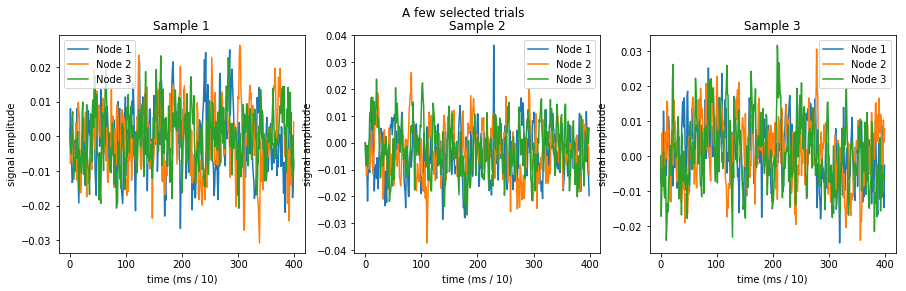

In [35]:
diagnostics.plot_samples(training_samples[0:3])

In [36]:
reload(gpcake)
reload(utility)
reload(diagnostics)
cake = gpcake.gpcake()
cake.initialize_time_parameters(time_step, time_period, ntime_points)
cake.dynamic_parameters["number_sources"] = p
cake.dynamic_type = "Relaxation"
cake.dynamic_parameters = simulation.dynamic_parameters
# This should be replaced by the univariate likelihood maximization for empirical data.

gp_cake/diagnostics.py:3: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/vol/optdcc/anaconda2/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/vol/optdcc/anaconda2/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/vol/optdcc/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/vol/optdcc/anaconda2/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/vol/optdcc/anaconda2/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 478, in start
    self.io_loop.start()
  File "/vol/opt

Training GP CaKe parameters with empirical Bayes.
Connectivity constraint: disabled.
Empirical Bayes procedure complete.


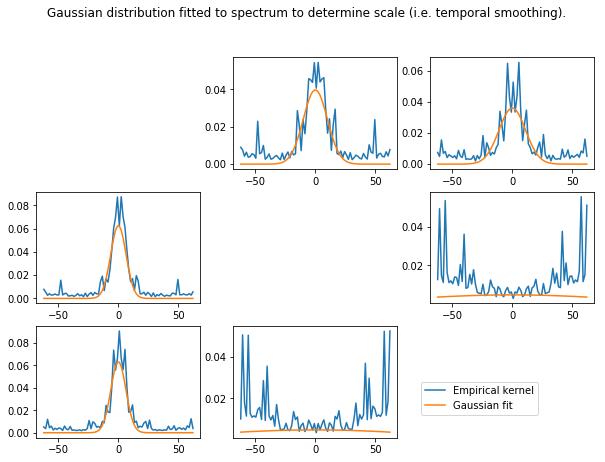

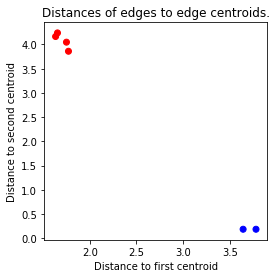

In [37]:
parameter_dict = cake.empirical_bayes_parameter_fit(training_samples, show_diagnostics=True)
# Note: our analysis fails if p=2, which induces symmetric log-likelihood ratios and scales,
# which causes their std to be 0 and hence the normalization throws an error.

GP CaKe parameters:

Time scales (nu_ij):
[[ 0.          0.12702564  0.12702564]
 [ 0.12702564  0.          0.01180061]
 [ 0.12702564  0.01180061  0.        ]]

Time shifts (t_ij):
[[ 0.          0.12702564  0.12702564]
 [ 0.12702564  0.          0.01180061]
 [ 0.12702564  0.01180061  0.        ]]

Spectral smoothing: (theta_ij)
[[  0.          12.70256397  12.70256397]
 [ 12.70256397   0.           1.18006133]
 [ 12.70256397   1.18006133   0.        ]]

Noise levels (sigma_i):
[ 0.6248011   0.65123823  0.65123823]

Connectivity constraint (G_ij):
[[ 0.  1.  1.]
 [ 1.  0.  1.]
 [ 1.  1.  0.]]
Elapsed time is 28.4781620502 seconds.
MSE: 0.021662
MSE: 0.021662


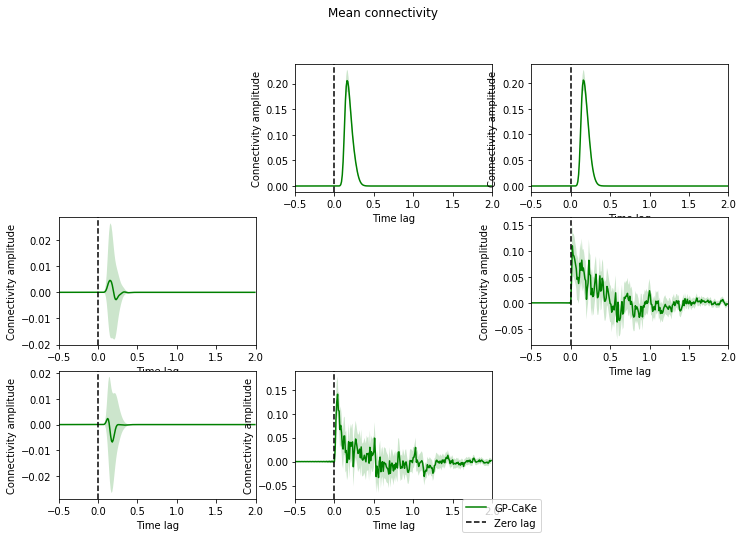

In [38]:
cake.parallelthreads = 1 # parallelization is broken after latest patch
connectivity = cake.run_analysis(testing_samples, show_diagnostics=True)
diagnostics.plot_connectivity(ground_truth, connectivity, time_range, t0=-0.5)

mse_scores = diagnostics.estimation_error(ground_truth, connectivity)
print 'MSE: %f' % np.mean(mse_scores)
print 'MSE: %f' % np.mean(mse_scores)

In [39]:
mse_scores = diagnostics.estimation_error(ground_truth, connectivity)
print 'MSE: %f' % np.mean(mse_scores)

MSE: 0.021662
